In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette='Set2')
import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default = "svg"

from scipy.stats import rv_continuous, kstest

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from typing import Any, Dict, Optional

from timeit import default_timer

import warnings
warnings.filterwarnings('ignore')

import nbimporter
from Functions import PurgedKFold, cvScore, get_test_data

## Auxilary Functions

In [2]:
class MyPipeline(Pipeline):
    '''
    Augmentation of sklearn Pipeline class that allows to pass 'sample_weight' to 'fit' method.
    '''
    def fit(
        self, X: pd.DataFrame, y: pd.Series, sample_weight: Optional[pd.Series] = None, **fit_params
    ) -> 'MyPipeline':
        if sample_weight is not None:
            fit_params[self.steps[-1][0] + '__sample_weight'] = sample_weight
        return super().fit(X, y, **fit_params)

In [3]:
def clf_hyper_fit_base(
    feat: pd.DataFrame, lbl: pd.Series, t1: pd.Series, pipe_clf: Any, param_grid: Dict[str, list],
    cv: int = 3, bagging: list = [0, None, 1.0], n_jobs: int = -1, pctEmbargo: float = 0.0, **fit_params
) -> Any:
    '''
    Implements purged GridSearchCV with a possibility of fitting bagging of tuned estimator.
    
        Parameters:
            feat (pd.DataFrame): features dataset
            lbl (pd.Series): labels
            t1 (pd.Series): start timestamps (t1.index) and end timestamps (t1.values) of observations
            pipe_clf (Any): classififer to fit
            param_grid (Dict[str, list]): dictionary with parameters values
            cv (int): number of splits
            bagging (list): bagging parameters (used when bagging[1] is not None)
            n_jobs (int): number of jobs to run in parallel
            pctEmbargo (float): share of observations to drop after train
        
        Returns:
            gs (Any): fitted best estimator found by grid search
    '''
    if set(lbl.values) == {0, 1}:
        scoring='f1'    # f1 for meta-labeling
    else:
        scoring='neg_log_loss'    # symmetric towards all cases
    inner_cv = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)    # purged
    gs=GridSearchCV(estimator=pipe_clf ,param_grid=param_grid, scoring=scoring, cv=inner_cv, n_jobs=n_jobs)
    gs = gs.fit(feat, lbl, **fit_params).best_estimator_    # pipeline
    if bagging[1] is not None and bagging[1] > 0:
        gs = BaggingClassifier(base_estimator=MyPipeline(gs.steps), n_estimators=int(bagging[0]),
                               max_samples=float(bagging[1]), max_features=float(bagging[2]), n_jobs=n_jobs)
        gs = gs.fit(feat, lbl, sample_weight=fit_params[gs.base_estimator.steps[-1][0]+'__sample_weight'])
        gs = Pipeline([('bag', gs)])
    return gs

In [8]:
# expand clf_hyper_fit_base to incorporate option to use randomized grid search
def clf_hyper_fit(
    feat: pd.DataFrame, lbl: pd.Series, t1: pd.Series, pipe_clf: Any, param_grid: Dict[str, list],
    cv: int = 3, bagging: list = [0, None, 1.0], rndSearchIter: int = 0,
    n_jobs: int = -1, pctEmbargo: float = 0.0, **fit_params
) -> Any:
    '''
    Implements purged GridSearchCV with a possibility of fitting bagging of tuned estimator.
    
        Parameters:
            feat (pd.DataFrame): features dataset
            lbl (pd.Series): labels
            t1 (pd.Series): start timestamps (t1.index) and end timestamps (t1.values) of observations
            pipe_clf (Any): classififer to fit
            param_grid (Dict[str, list]): dictionary with parameters values
            cv (int): number of splits
            bagging (list): bagging parameters (used when bagging[1] is not None)
            rndSearchIter (int): number of iterations to use in randomized GS (if 0 then apply standard GS)
            n_jobs (int): number of jobs to run in parallel
            pctEmbargo (float): share of observations to drop after train
        
        Returns:
            gs (Any): fitted best estimator found by grid search
    '''
    if set(lbl.values) == {0, 1}:
        scoring='f1'    # f1 for meta-labeling
    else:
        scoring='neg_log_loss'    # symmetric towards all cases
    inner_cv = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)    # purged
    
    if rndSearchIter == 0:
        gs = GridSearchCV(estimator=pipe_clf, param_grid=param_grid, scoring=scoring, cv=inner_cv, n_jobs=n_jobs)
    else:
        gs = RandomizedSearchCV(estimator=pipe_clf, param_distributions=param_grid, scoring=scoring,
                                cv=inner_cv, n_jobs=n_jobs, n_iter=rndSearchIter)
    gs = gs.fit(feat, lbl, **fit_params).best_estimator_    # pipeline
    
    if bagging[1] is not None and bagging[1] > 0:
        gs = BaggingClassifier(base_estimator=MyPipeline(gs.steps), n_estimators=int(bagging[0]),
                               max_samples=float(bagging[1]), max_features=float(bagging[2]), n_jobs=n_jobs)
        gs = gs.fit(feat, lbl, sample_weight=fit_params[gs.base_estimator.steps[-1][0]+'__sample_weight'])
        gs = Pipeline([('bag', gs)])
    return gs

In [5]:
class logUniform_gen(rv_continuous):
    '''
    Implements generator of log-uniform random variables.
    '''
    def _cdf(self, x: float) -> float:
        return np.log(x / self.a) / np.log(self.b / self.a)


def log_uniform(a: float = 1.0, b: float = np.exp(1.0)) -> 'logUniform_gen':
    return logUniform_gen(a=a, b=b, name='log_uniform')

Example:

KstestResult(statistic=0.008573147129436381, pvalue=0.4542750397879601)
count    10000.000000
mean        69.665528
std        172.653504
min          0.001000
25%          0.034666
50%          1.055682
75%         30.094845
max        999.756637
dtype: float64


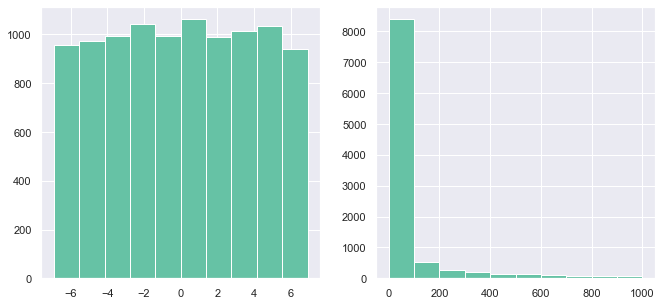

In [6]:
a, b, size = 1e-3, 1e3, 10000
vals = log_uniform(a=a, b=b).rvs(size=size)
print(kstest(rvs=np.log(vals), cdf='uniform', args=(np.log(a), np.log(b / a)), N=size))
print(pd.Series(vals).describe())
plt.figure(figsize=(11, 5))
plt.subplot(121)
pd.Series(np.log(vals)).hist()
plt.subplot(122)
pd.Series(vals).hist()
plt.show()

## Exercises

### 1.GridSearch on Synthetic Data

Here I apply GridSearch to a synthetic dataset. I use `timeit.default_timer` to measure time spent on fitting.

In [10]:
X, cont = get_test_data(n_features=10, n_informative=5, n_redundant=0, n_samples=2000)

clf = SVC(kernel='rbf', probability=True)
param_grid = {'C': [1e2, 1e-1, 1, 10, 100], 'gamma': [1e-2, 1e-1, 1, 10, 100]}

start_time = default_timer()
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1, cv=10)
gs.fit(X, cont['bin'], sample_weight=cont['w'])
end_time = default_timer()
print(f"Total fitting time: {end_time - start_time:.3f} seconds")

Total fitting time: 405.809 seconds


Best parameters:

In [11]:
gs.best_params_

{'C': 100.0, 'gamma': 0.1}

Best score:

In [12]:
print(f'Mean CV score: {gs.best_score_}')

Mean CV score: -0.2913886473171636


### 2. Randomized GridSearch on Synthetic Data

Here I apply Randomized GridSearch via the same function. The number of iterations is 25 which is the same as the number of nodes in the previous task.

In [13]:
clf = SVC(kernel='rbf', probability=True)
param_distributions = {'C': log_uniform(a=1e-2, b=1e2), 'gamma': log_uniform(a=1e-2, b=1e2)}

start_time = default_timer()
gs_rand = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, n_iter=25,
                             scoring='neg_log_loss', n_jobs=-1, cv=10)
gs_rand.fit(X, cont['bin'], sample_weight=cont['w'])
end_time = default_timer()
print(f"Total fitting time: {end_time - start_time:.3f} seconds")

Total fitting time: 379.966 seconds


Best parameters:

In [14]:
gs_rand.best_params_

{'C': 32.222054950379814, 'gamma': 0.05494236104173599}

Best score:

In [15]:
print(f'Mean CV score: {gs_rand.best_score_}')

Mean CV score: -0.33877779710671935


The best parameters of randomized GridSearch are quite close to those of the regular GridSearch, however, the score is lower.

### 3. Sharpe Ratio, Regular GridSearch

In [19]:
def get_IS_sharpe_ratio(clf: Any) -> float:
    '''
    Given a fitted gridsearch classifier, returns Sharpe ratio of the best estimator's in-sample forecasts.
    '''
    best_estimator_ind = np.argmin(clf.cv_results_['rank_test_score'])
    mean_score = clf.cv_results_['mean_test_score'][best_estimator_ind]
    std_score = clf.cv_results_['std_test_score'][best_estimator_ind]
    if mean_score < 0:
        return -mean_score / std_score
    else:
        return mean_score / std_score

Sharpe ratio of regular GridSearch, `neg_log_loss` scoring:

In [20]:
print(f'Sharpe ratio: {get_IS_sharpe_ratio(gs)}')

Sharpe ratio: 2.0717487544063835


Sharpe ratio of regular GridSearch, `accuracy` scoring (need to refit GridSearch):

In [21]:
start_time = default_timer()
gs_acc = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=10)
gs_acc.fit(X, cont['bin'], sample_weight=cont['w'])
end_time = default_timer()
print(f"Total fitting time: {end_time - start_time:.3f} seconds")

print(f'Sharpe ratio: {get_IS_sharpe_ratio(gs_acc)}')

Total fitting time: 305.060 seconds
Sharpe ratio: 11.700428101519837


As we see, `accuracy` scoring method gives much higher Sharpe ratio.

### 4. Sharpe Ratio, Randomized GridSearch

Sharpe ratio of randomized GridSearch, `neg_log_loss` scoring:

In [22]:
print(f'Sharpe ratio: {get_IS_sharpe_ratio(gs_rand)}')

Sharpe ratio: 2.005028594036192


Sharpe ratio of randomized GridSearch, `accuracy` scoring (need to refit GridSearch):

In [30]:
start_time = default_timer()
gs_rand_acc = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, n_iter=25,
                                 scoring='accuracy', n_jobs=-1, cv=10)
gs_rand_acc.fit(X, cont['bin'], sample_weight=cont['w'])
end_time = default_timer()
print(f"Total fitting time: {end_time - start_time:.3f} seconds")

print(f'Sharpe ratio: {get_IS_sharpe_ratio(gs_rand_acc)}')

Total fitting time: 268.132 seconds
Sharpe ratio: 11.8319056411605


In case of randomized GS, `accuracy` scoring method also gives much higher Sharpe ratio.